<a href="https://colab.research.google.com/github/talgalper/Honours-2021/blob/main/wilcoxon_stat_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install ncbi-blast+
!apt-get install exonerate
!apt-get install dssp
!pip install biostructmap

In [ ]:
import pandas as pd
from collections import defaultdict
import biostructmap

In [3]:
#read in data file and file in gaps with 0 values
def nextstrain_data_processing(filename, seq_len, gene_id):
    ns_data = pd.read_csv(filename, sep='\t')

    s_gene_data = ns_data[ns_data.gene == gene_id]

    pos = s_gene_data.position

    entropy = s_gene_data.entropy

    pos_to_entropy = defaultdict(float, zip(pos, entropy))

    len_of_ref_seq = seq_len

    list_of_values = [pos_to_entropy[i+1] for i in range(len_of_ref_seq)]
    return list_of_values

In [ ]:
s_protein_data = nextstrain_data_processing('/home/andrew/Downloads/nextstrain_ncov_global_diversity.tsv', 1273, 'S')

In [4]:
#removes fasta file header
def ref_seq_fasta_format(fasta_filename):
    with open(fasta_filename) as f:
        seq_lines = f.readlines()
    
    formatted_seq_lines = seq_lines[1:]
    
    new_list_lines_removed = list(map(str.strip, formatted_seq_lines)) 
    complete_format = ''.join(new_list_lines_removed)
    return complete_format

In [ ]:
ref_seq = ref_seq_fasta_format('sarscov2_s_protein.fasta')

In [ ]:
#check
ref_seq

'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITG

In [5]:
#Biostruct map initalisation
def biostructmap_analysis(pdb_structure, gene_name, input_data, ref_sequence, output_filename):
    structure = biostructmap.Structure(pdb_structure, gene_name)

    data = {'B': input_data, 
            'C': input_data, 
            'D': input_data
            }
 
    ref_seqs = {'B': ref_sequence,
                'C': ref_sequence,
                'D': ref_sequence
                }
    results = structure.map(data, method='default', ref=ref_seqs, radius=15, rsa_range=(0.2, 1.0))
    return results  # Note we are now returning the results object as well as saving data to a file. 

In [ ]:
mapped_diversity_data = biostructmap_analysis('S-prot.pdb', 'spike_protein', s_protein_data, ref_seq, '19biostructmap_diversity_jun_2021.pdb')

In [ ]:
# Get data for a particular residue:
chain_of_interest = 'B'
residue_id_of_interest = 25

# Need to use Biopython's slightly odd residue identifier syntax.
residue_of_interest = (chain_of_interest, (' ', residue_id_of_interest, ' '))
mapped_diversity_data[residue_of_interest]

In [ ]:
# How you might go about getting data out for all months:

month_data_files = ['month1.tsv', 'month2.tsv', 'month3.tsv'] # just an example
month_biostructmap_data = []

# Simply looping over all month files, performing analysis, saving results in a list.
for month_data in month_data_files:
    month_file_prefix = month_data.replace('.tsv', '')
    s_protein_data = nextstrain_data_processing(month_data, 1273, 'S')
    mapped_diversity_data = biostructmap_analysis('S-prot.pdb', 'spike_protein', s_protein_data, ref_seq, f"{month_file_prefix}_biostructmap.pdb")
    month_biostructmap_data.append(mapped_diversity_data)





# And now you can plot this using the `data_for_residue` list as your y values, and the months as your x values.

In [ ]:
# And this is how you might go about getting data out for a particular residue across all months
# Get data for a particular residue:
chain_of_interest = 'B'
residue_id_of_interest = 144

# Need to use Biopython's slightly odd residue identifier syntax.
residue_of_interest = (chain_of_interest, (' ', residue_id_of_interest, ' '))
data_for_residue = [x[residue_of_interest] for x in month_biostructmap_data]

In [ ]:
# Example of how you could pull out values across all months to then calculate stats on:
import numpy as np
residue_div_values_per_month = []
chain_of_interest = 'B' #Only calculate on a single chain

for single_month_data in month_biostructmap_data:
    diversity_values = [value for key, value in single_month_data.items() if key[0] == chain_of_interest]
    residue_div_values_per_month.append(diversity_values)

month_array = np.array(residue_div_values_per_month, dtype=float)

month_array = month_array[:, ~np.isnan(month_array).any(axis=0)]

In [ ]:
month_array.shape

(3, 529)

In [ ]:
from scipy.stats import wilcoxon

n_months = month_array.shape[0]
p_array = np.zeros((n_months, n_months))

for i in range(n_months):
    for j in range(n_months):
        if i != j:
            stat, p = wilcoxon(month_array[i], month_array[j])
            p_array[i][j] = p
        else:
            p_array[i][j] = 1.0


<AxesSubplot:>

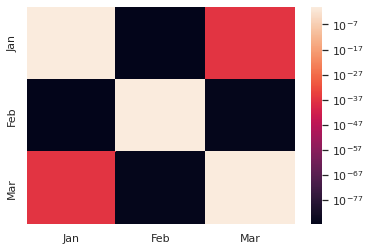

In [ ]:
import matplotlib.pyplot as plt

months = ['Jan', 'Feb', 'Mar']
import seaborn as sns; sns.set_theme()
from matplotlib.colors import LogNorm


sns.heatmap(p_array, norm=LogNorm(), xticklabels=months, yticklabels=months)


In [ ]:
pd.DataFrame({month: list(month_array[i]) for i, month in enumerate(months)})

,Jan,Feb,Mar
0,0.001563,0.054594,0.006250
1,0.001667,0.054300,0.006667
2,0.000000,0.106000,0.006667
3,0.000000,0.106286,0.007143
4,0.000000,0.115957,0.008696
...,...,...,...
524,0.000000,0.035610,0.000000
525,0.000000,0.035429,0.000000
526,0.000000,0.042941,0.000000
527,0.000000,0.001923,0.000000


<AxesSubplot:>

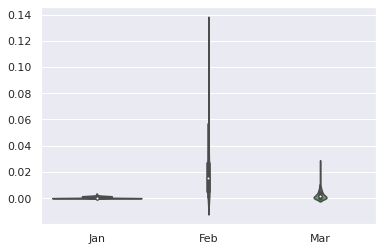

In [ ]:
df = pd.DataFrame({month: list(month_array[i]) for i, month in enumerate(months)})
sns.violinplot(data=df)